In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/epileptic-seizure-recognition/Epileptic Seizure Recognition.csv


Ανάπτυξη ενός μοντέλου Deep Learning (π.χ. CNN, LSTM ή hybrid) για ταξινόμηση EEG σημάτων σε:

Επιληπτικές κρίσεις (seizures) και

Κανονική δραστηριότητα (non-seizures)

In [2]:
pip install pandas numpy matplotlib scikit-learn tensorflow


Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

In [5]:
data = pd.read_csv('/kaggle/input/epileptic-seizure-recognition/Epileptic Seizure Recognition.csv')
data.head()

Unnamed   X1   X2   X3   X4   X5   X6   X7   X8   X9  ...  X170  X171  \
0  X21.V1.791  135  190  229  223  192  125   55   -9  -33  ...   -17   -15   
1  X15.V1.924  386  382  356  331  320  315  307  272  244  ...   164   150   
2     X8.V1.1  -32  -39  -47  -37  -32  -36  -57  -73  -85  ...    57    64   
3   X16.V1.60 -105 -101  -96  -92  -89  -95 -102 -100  -87  ...   -82   -81   
4   X20.V1.54   -9  -65  -98 -102  -78  -48  -16    0  -21  ...     4     2   

   X172  X173  X174  X175  X176  X177  X178  y  
0   -31   -77  -103  -127  -116   -83   -51  4  
1   146   152   157   156   154   143   129  1  
2    48    19   -12   -30   -35   -35   -36  5  
3   -80   -77   -85   -77   -72   -69   -65  5  
4   -12   -32   -41   -65   -83   -89   -73  5  

[5 rows x 180 columns]

Περιγραφή του Dataset EEG για Επιληπτικές Κρίσεις
Το αρχικό σύνολο δεδομένων αποτελείται από 5 διαφορετικούς φακέλους, όπου κάθε φάκελος περιλαμβάνει 100 αρχεία EEG. Κάθε αρχείο αντιστοιχεί σε έναν μόνο συμμετέχοντα (άτομο) και περιλαμβάνει καταγραφή της εγκεφαλικής δραστηριότητας για 23,6 δευτερόλεπτα.

🔹 Κάθε καταγραφή περιέχει 4097 χρονικά σημεία (samples), δηλαδή τιμές EEG με χρονική ανάλυση περίπου 1 δείγμα ανά 5.76 ms.

Επεξεργασία – Μετατροπή σε CSV
Για ευκολότερη πρόσβαση και επεξεργασία:

Κάθε καταγραφή (4097 σημεία) χωρίστηκε σε 23 αποσπάσματα (chunks) των 178 σημείων (που αντιστοιχούν σε περίπου 1 δευτερόλεπτο εγκεφαλικής δραστηριότητας).

Άρα συνολικά έχουμε 23 × 500 = 11.500 σειρές (παρατηρήσεις).

Κάθε γραμμή περιέχει:

178 μεταβλητές EEG (X1 έως X178)

1 ετικέτα (y) στην στήλη 179





Ερμηνεία των Κλάσεων (y)
Η μεταβλητή y αναπαριστά την κατηγορία της EEG καταγραφής: 


| Τιμή  | Περιγραφή                                           |
| ----- | --------------------------------------------------- |
| **1** | Επιληπτική κρίση (seizure activity) ✅               |
| **2** | Καταγραφή από την περιοχή **με όγκο** στον εγκέφαλο |
| **3** | Καταγραφή από υγιή περιοχή **σε άτομο με όγκο**     |
| **4** | **Μάτια κλειστά** κατά την καταγραφή                |
| **5** | **Μάτια ανοιχτά** κατά την καταγραφή                |

 Μόνο η κλάση 1 αντιστοιχεί σε επιληπτική κρίση. Όλες οι υπόλοιπες (2–5) θεωρούνται μη-επιληπτικές καταστάσεις.


In [7]:
data.isnull().sum()

Unnamed    0
X1         0
X2         0
X3         0
X4         0
          ..
X175       0
X176       0
X177       0
X178       0
y          0
Length: 180, dtype: int64

In [10]:
!pip install --upgrade scikit-learn imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 73.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

In [36]:
data = pd.read_csv('/kaggle/input/epileptic-seizure-recognition/Epileptic Seizure Recognition.csv')
data.head()

Unnamed   X1   X2   X3   X4   X5   X6   X7   X8   X9  X10  X11  X12  \
0  X21.V1.791  135  190  229  223  192  125   55   -9  -33  -38  -10   35   
1  X15.V1.924  386  382  356  331  320  315  307  272  244  232  237  258   
2     X8.V1.1  -32  -39  -47  -37  -32  -36  -57  -73  -85  -94  -99  -94   
3   X16.V1.60 -105 -101  -96  -92  -89  -95 -102 -100  -87  -79  -72  -68   
4   X20.V1.54   -9  -65  -98 -102  -78  -48  -16    0  -21  -59  -90 -103   

   X13  X14  X15  X16  X17   X18   X19   X20  X21  X22  X23  X24  X25  X26  \
0   64  113  152  164  127    50   -47  -121 -138 -125 -101  -50   11   39   
1  212    2 -267 -605 -850 -1001 -1109 -1090 -967 -746 -464 -152  118  318   
2  -96 -104 -103  -92  -75   -69   -69   -53  -37  -14  -10  -39  -78 -102   
3  -74  -80  -83  -73  -68   -61   -58   -59  -64  -79  -84  -97  -94  -84   
4  -84  -43   -9    3  -21   -60   -96  -103  -75  -29   14   55   78   73   

   X27  X28  X29  X30  X31  X32  X33  X34  X35  X36  X37  X38  X39  X40  X41  \
0   24   48   64   46   13  -19  -61  -96 -130 -132 -116 -115  -71  -14   25   
1  427  473  485  447  397  339  312  314  326  335  332  324  310  312  309   
2  -98  -80  -54  -40  -35  -39  -32  -13    7   34   41   33    6  -15  -30   
3  -77  -75  -72  -68  -76  -76  -72  -67  -69  -69  -69  -67  -68  -69  -67   
4   28  -13  -43  -68  -78  -75  -55  -41  -19  -20  -29  -36  -20    1   16   

   X42  X43  X44  X45  X46  X47  X48  X49  ...  X130  X131  X132  X133  X134  \
0   19    6    9   21   13  -37  -58  -33  ...   -23     8    42    77   103   
1  309  303  297  295  295  293  286  279  ... -1360  -662   -96   243   323   
2  -47  -53  -65  -64  -68  -85  -98 -109  ...   -60   -37   -26   -15    -6   
3  -66  -58  -54  -56  -70  -80  -82  -85  ...   -61   -66   -72   -88   -90   
4   14  -14  -42  -56  -45  -45  -45  -38  ...    55    54    38    19     4   

   X135  X136  X137  X138  X139  X140  X141  X142  X143  X144  X145  X146  \
0   135   121    79    59    43    54    90   111   107    64    32    18   
1   241    29  -167  -228  -136    27   146   229   269   297   307   303   
2   -14   -23   -34   -41   -54   -82  -107  -126  -124  -108   -84   -68   
3   -88   -77   -58   -53   -61   -69   -66   -74   -69   -61   -51   -45   
4    -1    10    22    26    37    38    26    10    -4   -13    -8     0   

   X147  X148  X149  X150  X151  X152  X153  X154  X155  X156  X157  X158  \
0   -25   -69   -65   -44   -33   -57   -88  -114  -130  -114   -83   -53   
1   305   306   307   280   231   159    85    51    43    62    63    63   
2   -61   -56   -63   -62   -33     1    28    45    37    48    62    80   
3   -45   -49   -58   -64   -78   -80   -90   -87   -83   -78   -64   -38   
4    10    19    29    57    63    45     7   -13   -23    -9     9    11   

   X159  X160  X161  X162  X163  X164  X165  X166  X167  X168  X169  X170  \
0   -79   -72   -85  -109   -98   -72   -65   -63   -11    10     8   -17   
1    69    89   123   136   127   102    95   105   131   163   168   164   
2    66    23   -11   -39   -44   -42   -45   -48   -42    -6    29    57   
3   -22   -29   -42   -51   -68   -71   -69   -69   -74   -74   -80   -82   
4     3    -1    -2     4    18    27    27    14    15    11    10     4   

   X171  X172  X173  X174  X175  X176  X177  X178  y  
0   -15   -31   -77  -103  -127  -116   -83   -51  4  
1   150   146   152   157   156   154   143   129  1  
2    64    48    19   -12   -30   -35   -35   -36  5  
3   -81   -80   -77   -85   -77   -72   -69   -65  5  
4     2   -12   -32   -41   -65   -83   -89   -73  5  

[5 rows x 180 columns]

In [37]:
data.isnull().sum()

Unnamed    0
X1         0
X2         0
X3         0
X4         0
          ..
X175       0
X176       0
X177       0
X178       0
y          0
Length: 180, dtype: int64

In [38]:
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

import plotly
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import init_notebook_mode, iplot



import seaborn as sns

init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 100)

In [39]:
data.shape

(11500, 180)

In [40]:
data['y'].value_counts()

y
4    2300
1    2300
5    2300
2    2300
3    2300
Name: count, dtype: int64

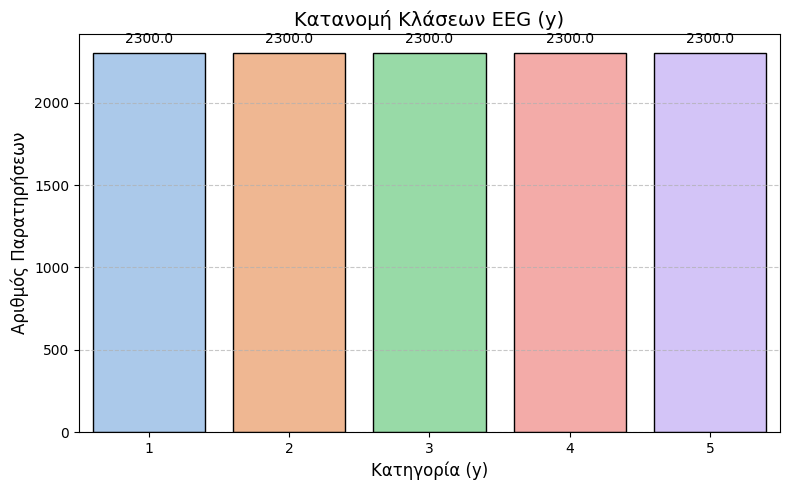

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(x=data['y'], palette='pastel', edgecolor='black')

plt.title('Κατανομή Κλάσεων EEG (y)', fontsize=14)
plt.xlabel('Κατηγορία (y)', fontsize=12)
plt.ylabel('Αριθμός Παρατηρήσεων', fontsize=12)

# Προσθήκη τιμών πάνω από τις μπάρες
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 10), 
                       textcoords='offset points')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Αντιπροσωπεύει τη συχνότητα εμφάνισης κάθε κλάσης (1–5) του στόχου y

Παρουσιάζεται με παστέλ χρώματα

Οι αριθμοί εμφανίζονται πάνω στις μπάρες για ευκολότερη κατανόηση

Είναι χρήσιμο για να δεις αν υπάρχει ανισορροπία μεταξύ των κλάσεων (όπως π.χ. λίγες κρίσεις σε σχέση με τις υπόλοιπες)

In [42]:
dic = {5: 0, 4: 0, 3: 0, 2: 0, 1: 1}
data['y'] = data['y'].map(dic)
print(data['y'].value_counts())

data.head()

y
0    9200
1    2300
Name: count, dtype: int64


Unnamed   X1   X2   X3   X4   X5   X6   X7   X8   X9  X10  X11  X12  \
0  X21.V1.791  135  190  229  223  192  125   55   -9  -33  -38  -10   35   
1  X15.V1.924  386  382  356  331  320  315  307  272  244  232  237  258   
2     X8.V1.1  -32  -39  -47  -37  -32  -36  -57  -73  -85  -94  -99  -94   
3   X16.V1.60 -105 -101  -96  -92  -89  -95 -102 -100  -87  -79  -72  -68   
4   X20.V1.54   -9  -65  -98 -102  -78  -48  -16    0  -21  -59  -90 -103   

   X13  X14  X15  X16  X17   X18   X19   X20  X21  X22  X23  X24  X25  X26  \
0   64  113  152  164  127    50   -47  -121 -138 -125 -101  -50   11   39   
1  212    2 -267 -605 -850 -1001 -1109 -1090 -967 -746 -464 -152  118  318   
2  -96 -104 -103  -92  -75   -69   -69   -53  -37  -14  -10  -39  -78 -102   
3  -74  -80  -83  -73  -68   -61   -58   -59  -64  -79  -84  -97  -94  -84   
4  -84  -43   -9    3  -21   -60   -96  -103  -75  -29   14   55   78   73   

   X27  X28  X29  X30  X31  X32  X33  X34  X35  X36  X37  X38  X39  X40  X41  \
0   24   48   64   46   13  -19  -61  -96 -130 -132 -116 -115  -71  -14   25   
1  427  473  485  447  397  339  312  314  326  335  332  324  310  312  309   
2  -98  -80  -54  -40  -35  -39  -32  -13    7   34   41   33    6  -15  -30   
3  -77  -75  -72  -68  -76  -76  -72  -67  -69  -69  -69  -67  -68  -69  -67   
4   28  -13  -43  -68  -78  -75  -55  -41  -19  -20  -29  -36  -20    1   16   

   X42  X43  X44  X45  X46  X47  X48  X49  ...  X130  X131  X132  X133  X134  \
0   19    6    9   21   13  -37  -58  -33  ...   -23     8    42    77   103   
1  309  303  297  295  295  293  286  279  ... -1360  -662   -96   243   323   
2  -47  -53  -65  -64  -68  -85  -98 -109  ...   -60   -37   -26   -15    -6   
3  -66  -58  -54  -56  -70  -80  -82  -85  ...   -61   -66   -72   -88   -90   
4   14  -14  -42  -56  -45  -45  -45  -38  ...    55    54    38    19     4   

   X135  X136  X137  X138  X139  X140  X141  X142  X143  X144  X145  X146  \
0   135   121    79    59    43    54    90   111   107    64    32    18   
1   241    29  -167  -228  -136    27   146   229   269   297   307   303   
2   -14   -23   -34   -41   -54   -82  -107  -126  -124  -108   -84   -68   
3   -88   -77   -58   -53   -61   -69   -66   -74   -69   -61   -51   -45   
4    -1    10    22    26    37    38    26    10    -4   -13    -8     0   

   X147  X148  X149  X150  X151  X152  X153  X154  X155  X156  X157  X158  \
0   -25   -69   -65   -44   -33   -57   -88  -114  -130  -114   -83   -53   
1   305   306   307   280   231   159    85    51    43    62    63    63   
2   -61   -56   -63   -62   -33     1    28    45    37    48    62    80   
3   -45   -49   -58   -64   -78   -80   -90   -87   -83   -78   -64   -38   
4    10    19    29    57    63    45     7   -13   -23    -9     9    11   

   X159  X160  X161  X162  X163  X164  X165  X166  X167  X168  X169  X170  \
0   -79   -72   -85  -109   -98   -72   -65   -63   -11    10     8   -17   
1    69    89   123   136   127   102    95   105   131   163   168   164   
2    66    23   -11   -39   -44   -42   -45   -48   -42    -6    29    57   
3   -22   -29   -42   -51   -68   -71   -69   -69   -74   -74   -80   -82   
4     3    -1    -2     4    18    27    27    14    15    11    10     4   

   X171  X172  X173  X174  X175  X176  X177  X178  y  
0   -15   -31   -77  -103  -127  -116   -83   -51  0  
1   150   146   152   157   156   154   143   129  1  
2    64    48    19   -12   -30   -35   -35   -36  0  
3   -81   -80   -77   -85   -77   -72   -69   -65  0  
4     2   -12   -32   -41   -65   -83   -89   -73  0  

[5 rows x 180 columns]

In [43]:
data = data.drop('Unnamed', axis = 1)
data.describe()

X1            X2            X3            X4            X5  \
count  11500.000000  11500.000000  11500.000000  11500.000000  11500.000000   
mean     -11.581391    -10.911565    -10.187130     -9.143043     -8.009739   
std      165.626284    166.059609    163.524317    161.269041    160.998007   
min    -1839.000000  -1838.000000  -1835.000000  -1845.000000  -1791.000000   
25%      -54.000000    -55.000000    -54.000000    -54.000000    -54.000000   
50%       -8.000000     -8.000000     -7.000000     -8.000000     -8.000000   
75%       34.000000     35.000000     36.000000     36.000000     35.000000   
max     1726.000000   1713.000000   1697.000000   1612.000000   1518.000000   

                 X6            X7           X8           X9           X10  \
count  11500.000000  11500.000000  11500.00000  11500.00000  11500.000000   
mean      -7.003478     -6.502087     -6.68713     -6.55800     -6.168435   
std      161.328725    161.467837    162.11912    162.03336    160.436352   
min    -1757.000000  -1832.000000  -1778.00000  -1840.00000  -1867.000000   
25%      -54.000000    -54.000000    -55.00000    -55.00000    -54.000000   
50%       -8.000000     -8.000000     -8.00000     -7.00000     -7.000000   
75%       36.000000     35.000000     36.00000     36.00000     35.250000   
max     1816.000000   2047.000000   2047.00000   2047.00000   2047.000000   

                X11           X12           X13           X14           X15  \
count  11500.000000  11500.000000  11500.000000  11500.000000  11500.000000   
mean      -5.827478     -6.042174     -6.687304     -7.088870     -7.211217   
std      160.471017    161.181118    165.071121    169.198359    170.641967   
min    -1765.000000  -1803.000000  -1833.000000  -1867.000000  -1870.000000   
25%      -54.000000    -54.000000    -54.000000    -54.000000    -53.000000   
50%       -8.000000     -8.000000     -8.000000     -8.000000     -7.000000   
75%       36.000000     35.000000     36.000000     37.000000     37.000000   
max     2047.000000   2047.000000   2047.000000   1829.000000   1631.000000   

                X16           X17           X18           X19           X20  \
count  11500.000000  11500.000000  11500.000000  11500.000000  11500.000000   
mean      -7.088261     -6.806696     -6.744696     -6.484783     -6.448435   
std      168.930355    164.646296    162.062661    162.571333    162.339911   
min    -1839.000000  -1867.000000  -1856.000000  -1844.000000  -1717.000000   
25%      -53.000000    -53.000000    -52.000000    -53.000000    -53.000000   
50%       -7.000000     -6.000000     -7.000000     -6.000000     -6.000000   
75%       38.000000     37.000000     38.000000     38.000000     39.000000   
max     1532.000000   1441.000000   1352.000000   1504.000000   1821.000000   

                X21           X22           X23           X24           X25  \
count  11500.000000  11500.000000  11500.000000  11500.000000  11500.000000   
mean      -6.355391     -6.543130     -6.884348     -6.883217     -6.118870   
std      162.823325    163.909723    165.844176    166.009100    164.715153   
min    -1764.000000  -1856.000000  -1844.000000  -1866.000000  -1863.000000   
25%      -53.000000    -53.000000    -53.000000    -52.000000    -52.000000   
50%       -7.000000     -6.000000     -6.000000     -7.000000     -7.000000   
75%       39.000000     38.000000     37.000000     38.000000     37.000000   
max     2022.000000   2047.000000   2040.000000   1879.000000   1666.000000   

               X26           X27           X28           X29           X30  \
count  11500.00000  11500.000000  11500.000000  11500.000000  11500.000000   
mean      -5.15913     -4.785652     -4.874783     -5.393565     -5.935478   
std      162.77423    162.902294    164.799831    165.391697    164.291120   
min    -1866.00000  -1781.000000  -1860.000000  -1818.000000  -1867.000000   
25%      -52.00000    -51.000000    -50.000000    -50.000000    -50.000000   
50%    

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 179 entries, X1 to y
dtypes: int64(179)
memory usage: 15.7 MB


In [45]:
X = data.drop('y', axis=1)
y = data['y']
df = pd.DataFrame(normalize(X))
df

0         1         2         3         4         5         6    \
0      0.104109  0.146523  0.176599  0.171972  0.148066  0.096397  0.042415   
1      0.061209  0.060575  0.056452  0.052488  0.050743  0.049951  0.048682   
2     -0.038444 -0.046854 -0.056465 -0.044451 -0.038444 -0.043250 -0.068479   
3     -0.111276 -0.107037 -0.101738 -0.097499 -0.094319 -0.100678 -0.108096   
4     -0.017182 -0.124093 -0.187094 -0.194730 -0.148911 -0.091638 -0.030546   
...         ...       ...       ...       ...       ...       ...       ...   
11495 -0.042703 -0.042703 -0.044644 -0.050468 -0.069878 -0.081525 -0.087348   
11496 -0.021589 -0.005053  0.012861  0.035369  0.064766  0.096920  0.112997   
11497  0.023487  0.010066 -0.021809 -0.026842  0.016776  0.043618  0.045296   
11498 -0.040310 -0.025194 -0.009070 -0.012093 -0.002015  0.012093  0.007054   
11499  0.043894  0.062058  0.086275  0.108979  0.112006  0.093843  0.081734   

            7         8         9         10        11        12        13   \
0     -0.006941 -0.025449 -0.029305 -0.007712  0.026991  0.049355  0.087143   
1      0.043132  0.038692  0.036789  0.037582  0.040912  0.033618  0.000317   
2     -0.087701 -0.102118 -0.112930 -0.118937 -0.112930 -0.115333 -0.124944   
3     -0.105977 -0.092200 -0.083722 -0.076303 -0.072064 -0.078423 -0.084781   
4      0.000000 -0.040092 -0.112638 -0.171821 -0.196639 -0.160366 -0.082092   
...         ...       ...       ...       ...       ...       ...       ...   
11495 -0.081525 -0.087348 -0.095112 -0.110641 -0.124228 -0.141698 -0.153344   
11496  0.110241  0.088652  0.062470  0.035828  0.003675 -0.030316 -0.060632   
11497 -0.015099  0.006711  0.023487 -0.001678 -0.016776  0.023487  0.073816   
11498  0.019147  0.022170  0.029225  0.022170  0.006046  0.001008 -0.028217   
11499  0.065085  0.046922  0.034813  0.019677  0.016650 -0.004541 -0.007568   

            14        15        16        17        18        19        20   \
0      0.117219  0.126473  0.097939  0.038559 -0.036245 -0.093312 -0.106422   
1     -0.042339 -0.095937 -0.134787 -0.158732 -0.175858 -0.172845 -0.153340   
2     -0.123742 -0.110527 -0.090104 -0.082895 -0.082895 -0.063673 -0.044451   
3     -0.087961 -0.077363 -0.072064 -0.064646 -0.061467 -0.062526 -0.067825   
4     -0.017182  0.005727 -0.040092 -0.114547 -0.183276 -0.196639 -0.143184   
...         ...       ...       ...       ...       ...       ...       ...   
11495 -0.147521 -0.135874 -0.122287 -0.110641 -0.110641 -0.097053 -0.087348   
11496 -0.082680 -0.096461 -0.104269 -0.103351 -0.097379 -0.088193 -0.077168   
11497  0.129177  0.102335  0.070460  0.053684  0.048651  0.036908  0.043618   
11498 -0.037287 -0.035271 -0.035271 -0.045349 -0.064496 -0.105814 -0.141085   
11499 -0.013622 -0.021190  0.001514  0.040867  0.090816  0.104438  0.104438   

            21        22        23        24        25        26        27   \
0     -0.096397 -0.077889 -0.038559  0.008483  0.030076  0.018508  0.037016   
1     -0.118296 -0.073578 -0.024103  0.018712  0.050426  0.067711  0.075005   
2     -0.016819 -0.012014 -0.046854 -0.093708 -0.122541 -0.117736 -0.096111   
3     -0.083722 -0.089021 -0.102798 -0.099618 -0.089021 -0.081602 -0.079483   
4     -0.055364  0.026728  0.105002  0.148911  0.139366  0.053455 -0.024819   
...         ...       ...       ...       ...       ...       ...       ...   
11495 -0.065996 -0.064055 -0.062114 -0.058232 -0.046586 -0.046586 -0.034939   
11496 -0.066144 -0.053742 -0.040422 -0.024804 -0.009646  0.002756  0.013321   
11497  0.058717  0.135888  0.110723  0.083881  0.095625  0.152664  0.202993   
11498 -0.158217 -0.158217 -0.148139 -0.154186 -0.148139 -0.126976 -0.112868   
11499  0.075680  0.049949  0.030272  0.022704  0.006054 -0.007568 -0.006054   

            28        29        30        31        32        33        34   \
0      0.049355  0.035474  0.010025 -0.014652 -0.047042 -0.074033 -0.100253   
1      0.076908  0.070882  0.062954  0.053756  0.049475  0

In [46]:
detected_outliers = 0
managed_outliers = 0

# Loop through each of the 178 explanatory variables and calculate the IQR and bounds
for col in df.columns[:-1]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify any data points that fall outside the bounds and either remove or adjust them
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    if outliers.any():
        detected_outliers += outliers.sum()

        
        df.loc[outliers, col] = np.nanmedian(df[col])
        managed_outliers += outliers.sum()

print(f"Detected {detected_outliers} outliers and managed {managed_outliers} outliers.")

Detected 8269 outliers and managed 8269 outliers.


In [47]:
df['y'] = y

print('Normalized Totall Mean VALUE for Epiletic: {}'.format((df[df['y'] == 1].describe().mean()).mean()))
print('Normalized Totall Std VALUE for Epiletic: {}'.format((df[df['y'] == 1].describe().std()).std()))

print('Normalized Totall Mean VALUE for NOT Epiletic: {}'.format((df[df['y'] == 0].describe().mean()).mean()))
print('Normalized Totall Std VALUE for NOT Epiletic: {}'.format((df[df['y'] == 0].describe().std()).std()))

Normalized Totall Mean VALUE for Epiletic: 287.5097360814575
Normalized Totall Std VALUE for Epiletic: 0.022484374805551686
Normalized Totall Mean VALUE for NOT Epiletic: 1150.0021298752129
Normalized Totall Std VALUE for NOT Epiletic: 0.0006105494417686749


In [48]:
df.head()

0         1         2         3         4         5         6  \
0  0.104109  0.146523  0.176599  0.171972  0.148066  0.096397  0.042415   
1  0.061209  0.060575  0.056452  0.052488  0.050743  0.049951  0.048682   
2 -0.038444 -0.046854 -0.056465 -0.044451 -0.038444 -0.043250 -0.068479   
3 -0.111276 -0.107037 -0.101738 -0.097499 -0.094319 -0.100678 -0.108096   
4 -0.017182 -0.124093 -0.187094 -0.194730 -0.148911 -0.091638 -0.030546   

          7         8         9        10        11        12        13  \
0 -0.006941 -0.025449 -0.029305 -0.007712  0.026991  0.049355  0.087143   
1  0.043132  0.038692  0.036789  0.037582  0.040912  0.033618  0.000317   
2 -0.087701 -0.102118 -0.112930 -0.118937 -0.112930 -0.115333 -0.124944   
3 -0.105977 -0.092200 -0.083722 -0.076303 -0.072064 -0.078423 -0.084781   
4  0.000000 -0.040092 -0.112638 -0.171821 -0.196639 -0.160366 -0.082092   

         14        15        16        17        18        19        20  \
0  0.117219  0.126473  0.097939  0.038559 -0.036245 -0.093312 -0.106422   
1 -0.042339 -0.095937 -0.134787 -0.158732 -0.175858 -0.172845 -0.153340   
2 -0.123742 -0.110527 -0.090104 -0.082895 -0.082895 -0.063673 -0.044451   
3 -0.087961 -0.077363 -0.072064 -0.064646 -0.061467 -0.062526 -0.067825   
4 -0.017182  0.005727 -0.040092 -0.114547 -0.183276 -0.196639 -0.143184   

         21        22        23        24        25        26        27  \
0 -0.096397 -0.077889 -0.038559  0.008483  0.030076  0.018508  0.037016   
1 -0.118296 -0.073578 -0.024103  0.018712  0.050426  0.067711  0.075005   
2 -0.016819 -0.012014 -0.046854 -0.093708 -0.122541 -0.117736 -0.096111   
3 -0.083722 -0.089021 -0.102798 -0.099618 -0.089021 -0.081602 -0.079483   
4 -0.055364  0.026728  0.105002  0.148911  0.139366  0.053455 -0.024819   

         28        29        30        31        32        33        34  \
0  0.049355  0.035474  0.010025 -0.014652 -0.047042 -0.074033 -0.100253   
1  0.076908  0.070882  0.062954  0.053756  0.049475  0.049792  0.051695   
2 -0.064875 -0.048055 -0.042048 -0.046854 -0.038444 -0.015618  0.008410   
3 -0.076303 -0.072064 -0.080542 -0.080542 -0.076303 -0.071004 -0.073124   
4 -0.082092 -0.129820 -0.148911 -0.143184 -0.105002 -0.078274 -0.036273   

         35        36        37        38        39        40        41  \
0 -0.101795 -0.089456 -0.088685 -0.054754 -0.010796  0.019279  0.014652   
1  0.053122  0.052646  0.051378  0.049158  0.049475  0.048999  0.048999   
2  0.040847  0.049257  0.039646  0.007208 -0.018021 -0.036042 -0.056465   
3 -0.073124 -0.073124 -0.071004 -0.072064 -0.073124 -0.071004 -0.069945   
4 -0.038182 -0.055364 -0.068728 -0.038182  0.001909  0.030546  0.026728   

         42        43        44        45        46        47        48  \
0  0.004627  0.006941  0.016195  0.010025 -0.028534 -0.044728 -0.025449   
1  0.048048  0.047096  0.046779  0.046779  0.046462  0.045352  0.044242   
2 -0.063673 -0.078090 -0.076889 -0.081694 -0.102118 -0.117736 -0.130951   
3 -0.061467 -0.057227 -0.059347 -0.074184 -0.084781 -0.086901 -0.090080   
4 -0.026728 -0.080183 -0.106911 -0.085910 -0.085910 -0.085910 -0.072547   

         49  ...       129       130       131       132       133       134  \
0  0.003856  ... -0.017737  0.006169  0.032389  0.059381  0.079431  0.104109   
1  0.044876  ... -0.215659 -0.104975 -0.015223  0.038533  0.051219  0.038216   
2 -0.098513  ... -0.072083 -0.044451 -0.031236 -0.018021 -0.007208 -0.016819   
3 -0.078423  ... -0.064646 -0.069945 -0.076303 -0.093260 -0.095379 -0.093260   
4 -0.089729  ...  0.105002  0.103092  0.072547  0.036273  0.007636 -0.001909   

        135       136       137       138       139       140       141  \
0  0.093312  0.060923  0.045499  0.033161  0.041644  0.069406  0.085601   
1  0.004599 -0.026482 -0.036155 -0.021566  0.004281  0.023152  0.036313   
2 -0.027632 -0.040847 -0.049257 -0.064875 -0.098513 -0.128548 -0.151374   
3 -0.081602 -0.061467 -0.056168 -0.064646 -0.073124 -0.069945 -0.078423 

In [49]:
df.shape

(11500, 179)

In [53]:
!pip install imbalanced-learn


In [57]:
import numpy as np
import pandas as pd

# Get the minority class
minority_class = data[data['y'] == 1]
majority_class = data[data['y'] == 0]

# Calculate how many samples to add
num_samples_to_add = len(majority_class) - len(minority_class)

# Randomly sample the minority class with replacement
oversampled_minority = minority_class.sample(n=num_samples_to_add, replace=True)

# Combine the majority class with the oversampled minority class
oversampled_data = pd.concat([majority_class, minority_class, oversampled_minority])

# Separate features (X) and target (y)
X = oversampled_data.drop('y', axis=1)
y = oversampled_data['y']

# Check the shape
print(X.shape, y.shape)



(18400, 178) (18400,)


In [58]:
data.corr()

X1        X2        X3        X4        X5        X6        X7  \
X1    1.000000  0.947729  0.808192  0.608109  0.393674  0.218226  0.103693   
X2    0.947729  1.000000  0.944623  0.790403  0.576579  0.369803  0.211793   
X3    0.808192  0.944623  1.000000  0.939522  0.778648  0.573874  0.382493   
X4    0.608109  0.790403  0.939522  1.000000  0.938636  0.784954  0.590497   
X5    0.393674  0.576579  0.778648  0.938636  1.000000  0.941267  0.792304   
...        ...       ...       ...       ...       ...       ...       ...   
X175  0.036144  0.024290  0.015536  0.016992  0.021924  0.022444  0.014869   
X176  0.030581  0.023906  0.016982  0.016911  0.018869  0.020977  0.017016   
X177  0.024562  0.021962  0.017070  0.014671  0.013607  0.017383  0.018572   
X178  0.020022  0.018059  0.012419  0.006226  0.001298  0.004240  0.008325   
y    -0.031262 -0.024503 -0.015615 -0.002149  0.013362  0.030168  0.041501   

            X8        X9       X10       X11       X12       X13       X14  \
X1    0.044483  0.027923  0.032221  0.040119  0.035647  0.009950 -0.027824   
X2    0.109478  0.060218  0.043565  0.042230  0.038162  0.019416 -0.007544   
X3    0.231084  0.133249  0.080003  0.054331  0.041668  0.026530  0.011323   
X4    0.399855  0.250052  0.150284  0.088767  0.056826  0.035834  0.025675   
X5    0.596424  0.410651  0.265112  0.159434  0.095688  0.056095  0.039551   
...        ...       ...       ...       ...       ...       ...       ...   
X175 -0.000510 -0.018552 -0.036517 -0.048852 -0.046327 -0.033726 -0.011371   
X176  0.005851 -0.009052 -0.025522 -0.039578 -0.043920 -0.041987 -0.029456   
X177  0.012590  0.001943 -0.011809 -0.025523 -0.034905 -0.041733 -0.038346   
X178  0.008032  0.004823 -0.001332 -0.009029 -0.016943 -0.026486 -0.027546   
y     0.043528  0.046100  0.052803  0.056550  0.051614  0.037665  0.026927   

           X15       X16       X17       X18       X19       X20       X21  \
X1   -0.067519 -0.103498 -0.129956 -0.140550 -0.136456 -0.116471 -0.089462   
X2   -0.037875 -0.068782 -0.098616 -0.121110 -0.133449 -0.129880 -0.115972   
X3   -0.008082 -0.033320 -0.065669 -0.100113 -0.128104 -0.140955 -0.140121   
X4    0.013586 -0.006570 -0.038564 -0.078758 -0.115846 -0.140112 -0.150236   
X5    0.027529  0.010352 -0.018654 -0.056762 -0.093578 -0.122881 -0.141336   
...        ...       ...       ...       ...       ...       ...       ...   
X175  0.008013  0.027385  0.043492  0.051453  0.053023  0.045683  0.033332   
X176 -0.014323  0.005739  0.025587  0.039846  0.049149  0.046909  0.037751   
X177 -0.028423 -0.009927  0.011446  0.031190  0.047308  0.050317  0.044180   
X178 -0.021912 -0.006436  0.012654  0.033186  0.052122  0.058078  0.054310   
y     0.020185  0.017560  0.015835  0.013904  0.014147  0.015235  0.017070   

           X22       X23       X24       X25       X26       X27       X28  \
X1   -0.059348 -0.032130 -0.003778  0.022393  0.045038  0.065780  0.085341   
X2   -0.092897 -0.066815 -0.035261 -0.002148  0.028793  0.058568  0.087011   
X3   -0.125213 -0.102256 -0.070201 -0.034079  0.001818  0.036775  0.069815   
X4   -0.144151 -0.127593 -0.099149 -0.063818 -0.026676  0.008765  0.041272   
X5   -0.145120 -0.137250 -0.115678 -0.084971 -0.049625 -0.017431  0.009565   
...        ...       ...       ...       ...       ...       ...       ...   
X175  0.017697  0.008395  0.004586  0.010144  0.016589  0.021305  0.013071   
X176  0.019404  0.006017 -0.001569  0.001109  0.006295  0.009184  0.001046   
X177  0.024560  0.008454 -0.000978  0.000248  0.003786  0.003836 -0.004405   
X178  0.036803  0.020389  0.011059  0.011635  0.012681  0.008549 -0.001032   
y     0.015495  0.013360  0.016949  0.027434  0.039552  0.040082  0.035254   

           X29       X30       X31       X32       X33       X34       X35  \
X1    0.106417  0.122688  0.129460  0.121796  0.101925  0.076640  0.050850   
X2    0.114048  0.134293  0.140905  0.130957  0.106961  0.078605  0.050587   
X3    0.099279  0.122287  0.13

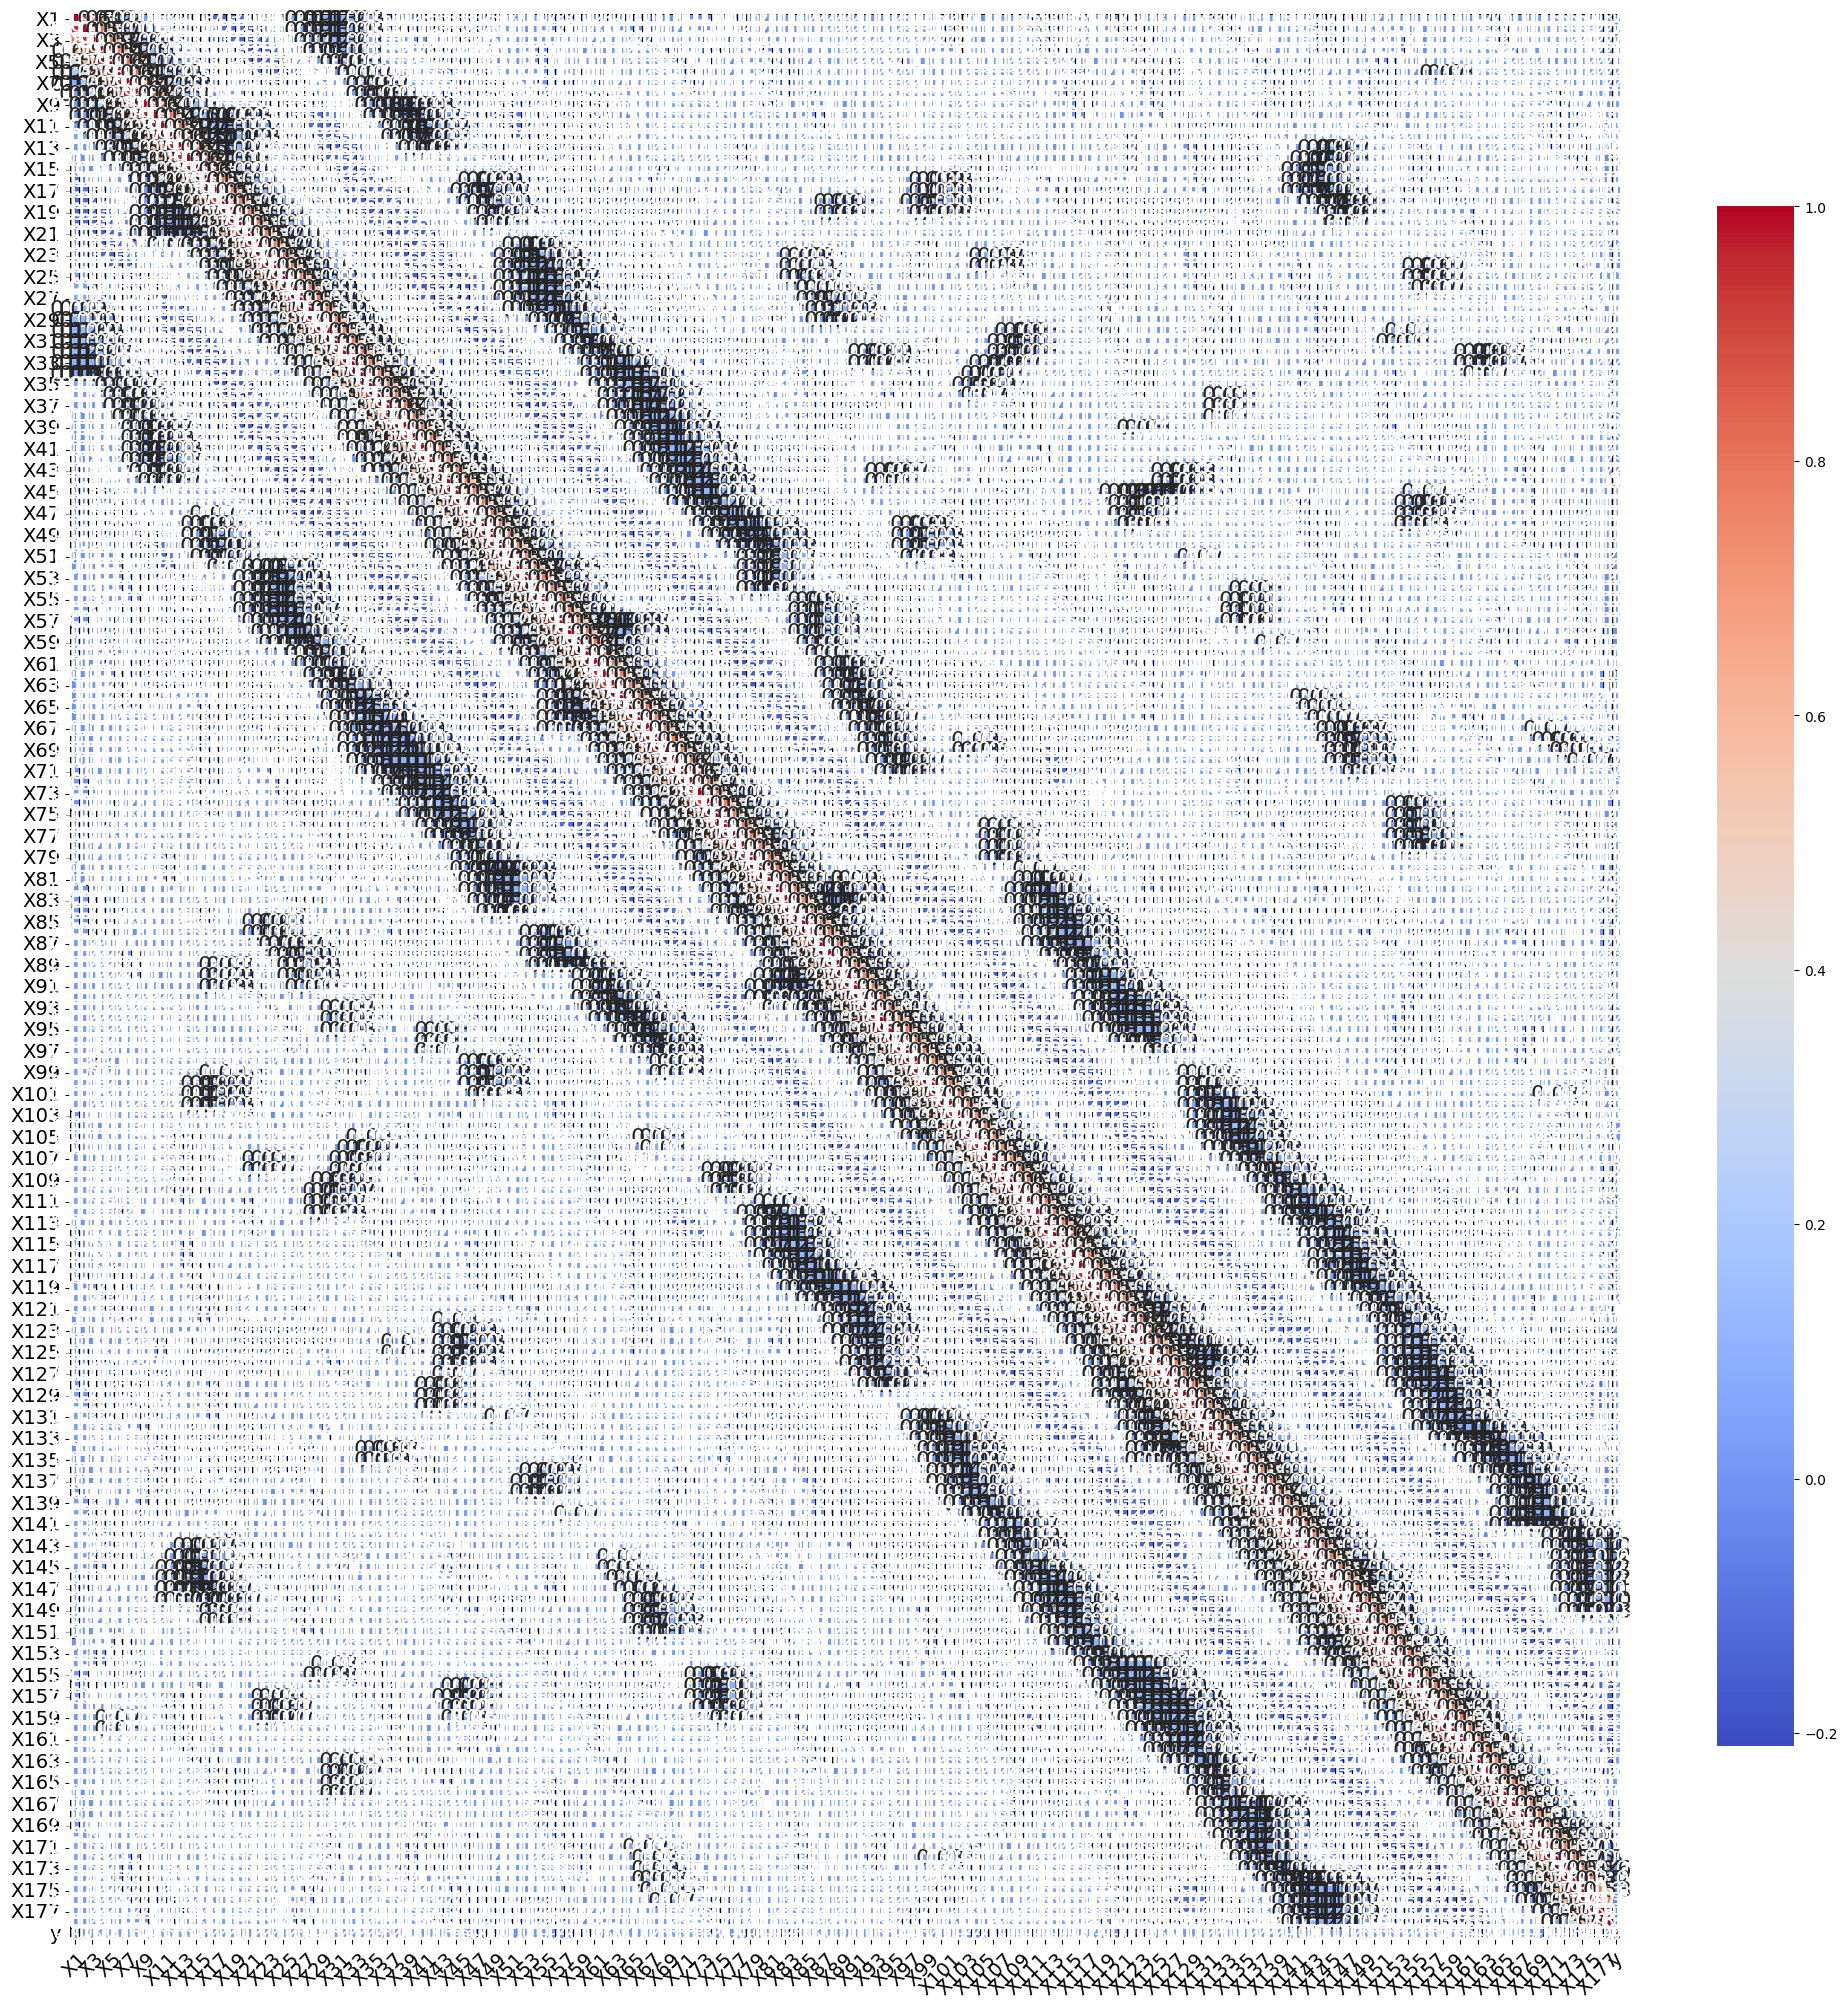

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis
fig, ax = plt.subplots(figsize=(25, 25))

# Create the heatmap with improved styling
sns.heatmap(
    data.corr(), 
    annot=True,                # Show the values in the heatmap
    fmt=".2f",                 # Format the numbers to 2 decimal places
    cmap="coolwarm",           # Choose a more visually appealing color palette
    annot_kws={"size": 16},    # Increase annotation font size
    cbar_kws={'shrink': 0.8},  # Adjust the color bar size
    linewidths=0.5,            # Add space between cells
    linecolor='black'          # Set color of the lines separating cells
)

# Adjust the axis labels
plt.xticks(fontsize=14, rotation=45)  # Make x-axis labels larger and rotated
plt.yticks(fontsize=14, rotation=0)   # Make y-axis labels larger

# Show the plot
plt.show()


In [60]:
print('Number of records of Non Epileptic {0} VS Epilepttic {1}'.format(len(y == True), len(y == False)))

Number of records of Non Epileptic 18400 VS Epilepttic 18400


In [65]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes after splitting
shapes = [X_train.shape, X_test.shape, y_train.shape, y_test.shape]
print(shapes)


[(14720, 178), (3680, 178), (14720,), (3680,)]


In [66]:
odels = [LogisticRegression(), SVC(),
          DecisionTreeClassifier(),
          RandomForestClassifier(), 
          GradientBoostingClassifier(),
          KNeighborsClassifier()]

#Check the correctness of list of classifiers and also 
model_name = [type(model).__name__ for model in models]
print(model_name)

# all parameters are not specified are set to their defaults
def classifiers(models):
    columns = ['Score', 'Predictions']
    df_result = pd.DataFrame(columns=columns, index=[type(model).__name__ for model in models])

    for model in models:
        clf = model
        print('Initialized classifier {} with default parameters \n'.format(type(model).__name__))    
        clf.fit(X_train, y_train)
        #make a predicitions for entire data(X_test)
        predictions = clf.predict(X_test)
        # Use score method to get accuracy of model
        score = clf.score(X_test, y_test)
        print('Score of classifier {} is: {} \n'.format(type(model).__name__, score))
        df_result['Score']['{}'.format(type(model).__name__)] = str(round(score * 100, 2)) + '%' 
        df_result['Predictions']['{}'.format(type(model).__name__)] = predictions
    return df_result

['LogisticRegression', 'SVC', 'DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier', 'KNeighborsClassifier']


In [67]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Sample dataset split (assuming X and y are already defined)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of classifiers
classifiers = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC()),
    ('KNN', KNeighborsClassifier())
]

# Loop through the classifiers, train them, and print accuracy
for name, clf in classifiers:
    # Train the model
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print the classifier name and accuracy
    print(f'{name} Accuracy: {accuracy:.4f}')


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic Regression Accuracy: 0.6163
Decision Tree Accuracy: 0.9734
Random Forest Accuracy: 0.9886
SVM Accuracy: 0.9696
KNN Accuracy: 0.9601


In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Sample dataset split (assuming X and y are already defined)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of classifiers
classifiers = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC()),
    ('KNN', KNeighborsClassifier())
]

# Create an empty list to store the results
results = []

# Loop through the classifiers, train them, and evaluate
for name, clf in classifiers:
    # Train the model
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the results to the list
    results.append([name, accuracy])

# Create a DataFrame to display the results in a table format
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy'])

# Display the table
print(results_df)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



                 Model  Accuracy
0  Logistic Regression  0.616304
1        Decision Tree  0.973913
2        Random Forest  0.988587
3                  SVM  0.969565
4                  KNN  0.960054


In [71]:
model=model.fit(X_train,y_train)
pred=model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print("Confusion Matrix:\n",confusion_matrix(y_test,pred))
print("Classification Report:\n",classification_report(y_test,pred))

Confusion Matrix:
 [[1816   33]
 [   1 1830]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1849
           1       0.98      1.00      0.99      1831

    accuracy                           0.99      3680
   macro avg       0.99      0.99      0.99      3680
weighted avg       0.99      0.99      0.99      3680



In [72]:
ESR = pd.read_csv('/kaggle/input/epileptic-seizure-recognition/Epileptic Seizure Recognition.csv')
ESR = ESR.drop(columns = ESR.columns[0]) 
ESR.head()

X1   X2   X3   X4   X5   X6   X7   X8   X9  X10  X11  X12  X13  X14  X15  \
0  135  190  229  223  192  125   55   -9  -33  -38  -10   35   64  113  152   
1  386  382  356  331  320  315  307  272  244  232  237  258  212    2 -267   
2  -32  -39  -47  -37  -32  -36  -57  -73  -85  -94  -99  -94  -96 -104 -103   
3 -105 -101  -96  -92  -89  -95 -102 -100  -87  -79  -72  -68  -74  -80  -83   
4   -9  -65  -98 -102  -78  -48  -16    0  -21  -59  -90 -103  -84  -43   -9   

   X16  X17   X18   X19   X20  X21  X22  X23  X24  X25  X26  X27  X28  X29  \
0  164  127    50   -47  -121 -138 -125 -101  -50   11   39   24   48   64   
1 -605 -850 -1001 -1109 -1090 -967 -746 -464 -152  118  318  427  473  485   
2  -92  -75   -69   -69   -53  -37  -14  -10  -39  -78 -102  -98  -80  -54   
3  -73  -68   -61   -58   -59  -64  -79  -84  -97  -94  -84  -77  -75  -72   
4    3  -21   -60   -96  -103  -75  -29   14   55   78   73   28  -13  -43   

   X30  X31  X32  X33  X34  X35  X36  X37  X38  X39  X40  X41  X42  X43  X44  \
0   46   13  -19  -61  -96 -130 -132 -116 -115  -71  -14   25   19    6    9   
1  447  397  339  312  314  326  335  332  324  310  312  309  309  303  297   
2  -40  -35  -39  -32  -13    7   34   41   33    6  -15  -30  -47  -53  -65   
3  -68  -76  -76  -72  -67  -69  -69  -69  -67  -68  -69  -67  -66  -58  -54   
4  -68  -78  -75  -55  -41  -19  -20  -29  -36  -20    1   16   14  -14  -42   

   X45  X46  X47  X48  X49  X50  ...  X130  X131  X132  X133  X134  X135  \
0   21   13  -37  -58  -33    5  ...   -23     8    42    77   103   135   
1  295  295  293  286  279  283  ... -1360  -662   -96   243   323   241   
2  -64  -68  -85  -98 -109  -82  ...   -60   -37   -26   -15    -6   -14   
3  -56  -70  -80  -82  -85  -74  ...   -61   -66   -72   -88   -90   -88   
4  -56  -45  -45  -45  -38  -47  ...    55    54    38    19     4    -1   

   X136  X137  X138  X139  X140  X141  X142  X143  X144  X145  X146  X147  \
0   121    79    59    43    54    90   111   107    64    32    18   -25   
1    29  -167  -228  -136    27   146   229   269   297   307   303   305   
2   -23   -34   -41   -54   -82  -107  -126  -124  -108   -84   -68   -61   
3   -77   -58   -53   -61   -69   -66   -74   -69   -61   -51   -45   -45   
4    10    22    26    37    38    26    10    -4   -13    -8     0    10   

   X148  X149  X150  X151  X152  X153  X154  X155  X156  X157  X158  X159  \
0   -69   -65   -44   -33   -57   -88  -114  -130  -114   -83   -53   -79   
1   306   307   280   231   159    85    51    43    62    63    63    69   
2   -56   -63   -62   -33     1    28    45    37    48    62    80    66   
3   -49   -58   -64   -78   -80   -90   -87   -83   -78   -64   -38   -22   
4    19    29    57    63    45     7   -13   -23    -9     9    11     3   

   X160  X161  X162  X163  X164  X165  X166  X167  X168  X169  X170  X171  \
0   -72   -85  -109   -98   -72   -65   -63   -11    10     8   -17   -15   
1    89   123   136   127   102    95   105   131   163   168   164   150   
2    23   -11   -39   -44   -42   -45   -48   -42    -6    29    57    64   
3   -29   -42   -51   -68   -71   -69   -69   -74   -74   -80   -82   -81   
4    -1    -2     4    18    27    27    14    15    11    10     4     2   

   X172  X173  X174  X175  X176  X177  X178  y  
0   -31   -77  -103  -127  -116   -83   -51  4  
1   146   152   157   156   154   143   129  1  
2    48    19   -12   -30   -35   -35   -36  5  
3   -80   -77   -85   -77   -72   -69   -65  5  
4   -12   -32   -41   -65   -83   -89   -73  5  

[5 rows x 179 columns]

The number of trials for the non-seizure class is: 9200
The number of trials for the seizure class is: 2300


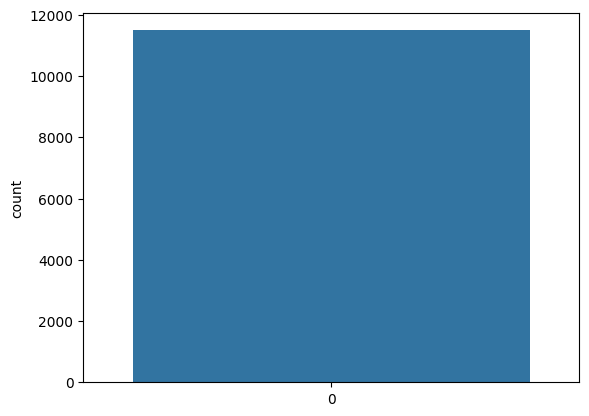

In [73]:
cols = ESR.columns
tgt = ESR.y
tgt[tgt > 1] = 0
ax = sn.countplot(tgt,label="Count")
non_seizure, seizure = tgt.value_counts()
print('The number of trials for the non-seizure class is:', non_seizure)
print('The number of trials for the seizure class is:', seizure)

In [74]:
ESR.describe()

X1            X2            X3            X4            X5  \
count  11500.000000  11500.000000  11500.000000  11500.000000  11500.000000   
mean     -11.581391    -10.911565    -10.187130     -9.143043     -8.009739   
std      165.626284    166.059609    163.524317    161.269041    160.998007   
min    -1839.000000  -1838.000000  -1835.000000  -1845.000000  -1791.000000   
25%      -54.000000    -55.000000    -54.000000    -54.000000    -54.000000   
50%       -8.000000     -8.000000     -7.000000     -8.000000     -8.000000   
75%       34.000000     35.000000     36.000000     36.000000     35.000000   
max     1726.000000   1713.000000   1697.000000   1612.000000   1518.000000   

                 X6            X7           X8           X9           X10  \
count  11500.000000  11500.000000  11500.00000  11500.00000  11500.000000   
mean      -7.003478     -6.502087     -6.68713     -6.55800     -6.168435   
std      161.328725    161.467837    162.11912    162.03336    160.436352   
min    -1757.000000  -1832.000000  -1778.00000  -1840.00000  -1867.000000   
25%      -54.000000    -54.000000    -55.00000    -55.00000    -54.000000   
50%       -8.000000     -8.000000     -8.00000     -7.00000     -7.000000   
75%       36.000000     35.000000     36.00000     36.00000     35.250000   
max     1816.000000   2047.000000   2047.00000   2047.00000   2047.000000   

                X11           X12           X13           X14           X15  \
count  11500.000000  11500.000000  11500.000000  11500.000000  11500.000000   
mean      -5.827478     -6.042174     -6.687304     -7.088870     -7.211217   
std      160.471017    161.181118    165.071121    169.198359    170.641967   
min    -1765.000000  -1803.000000  -1833.000000  -1867.000000  -1870.000000   
25%      -54.000000    -54.000000    -54.000000    -54.000000    -53.000000   
50%       -8.000000     -8.000000     -8.000000     -8.000000     -7.000000   
75%       36.000000     35.000000     36.000000     37.000000     37.000000   
max     2047.000000   2047.000000   2047.000000   1829.000000   1631.000000   

                X16           X17           X18           X19           X20  \
count  11500.000000  11500.000000  11500.000000  11500.000000  11500.000000   
mean      -7.088261     -6.806696     -6.744696     -6.484783     -6.448435   
std      168.930355    164.646296    162.062661    162.571333    162.339911   
min    -1839.000000  -1867.000000  -1856.000000  -1844.000000  -1717.000000   
25%      -53.000000    -53.000000    -52.000000    -53.000000    -53.000000   
50%       -7.000000     -6.000000     -7.000000     -6.000000     -6.000000   
75%       38.000000     37.000000     38.000000     38.000000     39.000000   
max     1532.000000   1441.000000   1352.000000   1504.000000   1821.000000   

                X21           X22           X23           X24           X25  \
count  11500.000000  11500.000000  11500.000000  11500.000000  11500.000000   
mean      -6.355391     -6.543130     -6.884348     -6.883217     -6.118870   
std      162.823325    163.909723    165.844176    166.009100    164.715153   
min    -1764.000000  -1856.000000  -1844.000000  -1866.000000  -1863.000000   
25%      -53.000000    -53.000000    -53.000000    -52.000000    -52.000000   
50%       -7.000000     -6.000000     -6.000000     -7.000000     -7.000000   
75%       39.000000     38.000000     37.000000     38.000000     37.000000   
max     2022.000000   2047.000000   2040.000000   1879.000000   1666.000000   

               X26           X27           X28           X29           X30  \
count  11500.00000  11500.000000  11500.000000  11500.000000  11500.000000   
mean      -5.15913     -4.785652     -4.874783     -5.393565     -5.935478   
std      162.77423    162.902294    164.799831    165.391697    164.291120   
min    -1866.00000  -1781.000000  -1860.000000  -1818.000000  -1867.000000   
25%      -52.00000    -51.000000    -50.000000    -50.000000    -50.000000   
50%    

In [75]:
Y = ESR.iloc[:,178].values
Y.shape

(11500,)

In [76]:
Y[Y>1]=0
Y

array([0, 1, 0, ..., 0, 0, 0])

In [77]:
X = ESR.iloc[:,1:178].values
X.shape

(11500, 177)

In [78]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [79]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)
y_pred_svc = clf.predict(X_test)
acc_svc = round(clf.score(X_train, y_train) * 100, 2)
print("Accuracy is:",(str(acc_svc)+'%'))

Accuracy is: 98.2%


In [80]:
new_input1 = [ESR.iloc[6, :177]]
new_input1

[X1      -55
 X2       -9
 X3       52
 X4      111
 X5      135
        ... 
 X173    -62
 X174    -41
 X175    -26
 X176     11
 X177     67
 Name: 6, Length: 177, dtype: int64]

In [81]:
new_output = clf.predict(new_input1)
new_output

array([1])

In [84]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1)
print(X.shape,y.shape)
X_train

(11500, 177) (18400,)


array([[-163, -155, -136, ...,  -99,  -87,  -83],
       [-279, -271, -163, ...,  -89,  -68,  -55],
       [  51,   54,   42, ...,   40,    8,   -4],
       ...,
       [  70,  117,   78, ...,   58,   88,   29],
       [  -1,   22,   42, ...,  -12,   -9,   -2],
       [ -22,  -11,  -10, ...,   25,   18,   11]])

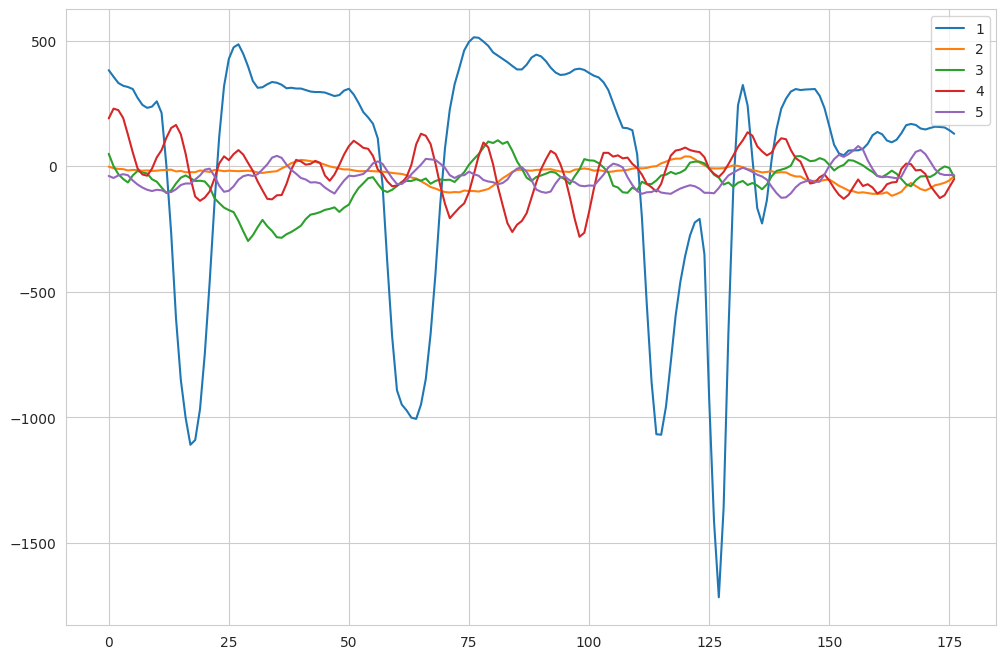

In [86]:
plt.figure(figsize=(12,8))
plt.plot(X[1,:],label='1')
plt.plot(X[7,:],label='2')
plt.plot(X[12,:],label='3')
plt.plot(X[0,:],label='4')
plt.plot(X[2,:],label='5')
plt.legend()
plt.show()